In [2]:
#data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Prep
from pythainlp import  word_tokenize
from pythainlp.util import dict_trie
from pythainlp.spell import correct_sent
from pythainlp.util import normalize , maiyamok,reorder_vowels,emoji_to_thai
from pythainlp.corpus.common import thai_stopwords,thai_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from pythainlp.tokenize import Tokenizer
#ALgorithm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

In [3]:
df = pd.read_csv('trainset.csv')
df

,Text,Sentiment
0,หาก แต่เพราะว่าอาจารย์ นั้นอาวุโสเเล้วจึงทำให้...,Negative
1,ผมอยากให้มีสื่อการสอนมากกว่านี้ครับ ดูจากสื่อป...,Negative
2,อยากให้อาจารย์มีความยืดหยุ่นในการใช้แกรมม่าให้...,Negative
3,อาจารย์พูดเสมอเลยว่าเข้าใจว่ารายวิชานี้ไม่เห...,Negative
4,ข้อสอบอาจารย์ยากเกินไปค่ะ ไม่เหมือนกับที่อาจาร...,Negative
...,...,...
22904,ข้อแนะนำ : อยากให้วิชานี้เปิดสอนในเทอมต้น เนื่...,Positive
22905,อาจารย์ท่านที่ใส่แว่นใจดีมากๆค่ะตอบคำถามได้ละเ...,Positive
22906,คำชม อาจารย์เน้นสอนเข้าใจ ก่อนเรียนมีการทบทวนเ...,Positive
22907,อยากให้อาจารย์มีคลิปย้อนหลังให้ค่ะ หนูตามไม่ทั...,Negative


<Axes: xlabel='Sentiment'>

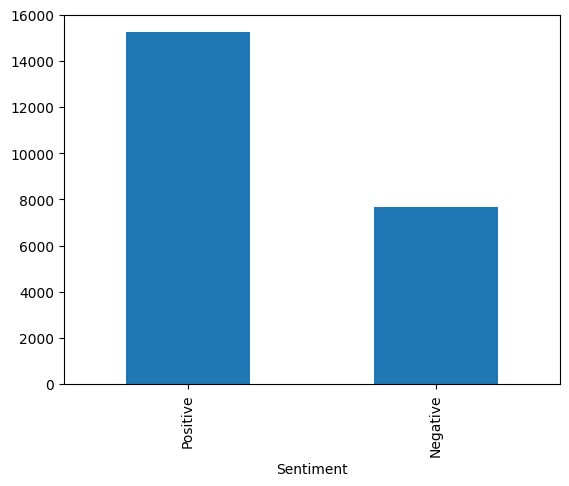

In [4]:
df['Sentiment'].value_counts().plot.bar()

In [5]:
stopword=pd.read_csv("stopword.txt")
stopword=list(stopword["word"])
# stopword.append('าา')
stopword.append('\n')
stopword.append('/')
stopword.append(',')
stopword.append('บบบ')
stopword.append(";")
stopword.append("รึ")
# stopword.append("เค้า")
# stopword.append("&")
# stopword.append("ㅠ_ㅠ")
# stopword.append("☺️")
# stopword.append("→")
stopword

FileNotFoundError: [Errno 2] No such file or directory: 'stopword.txt'

In [10]:
from pythainlp.util import dict_trie

# สร้างพจนานุกรมแบบกำหนดเอง
custom_dict = set(["อาจารย์", "อุปกรณ์","แสดง"])

# สร้างต้นไม้แบบ Trie จากพจนานุกรม
trie = dict_trie(dict_source=custom_dict)

In [11]:
def text_process(text):
    text = text.lower()
#token -> stopword
    text = word_tokenize(text,engine='newmm',keep_whitespace=False)
    text = [i for i in text if i not in stopword]
    text = " ".join(text)
#     text = " ".join(char for char in text if char not in emoji.UNICODE_EMOJI)
    return text

In [12]:
df['text_tokens'] = df['Text'].apply(text_process)
df

,Text,Sentiment,text_tokens
0,หาก แต่เพราะว่าอาจารย์ นั้นอาวุโสเเล้วจึงทำให้...,Negative,แต่ เพราะว่า อาจารย์ อาวุโส เเล้ว จึง ทำให้ ยั...
1,ผมอยากให้มีสื่อการสอนมากกว่านี้ครับ ดูจากสื่อป...,Negative,อยาก ให้ มี สื่อการสอน มากกว่า ดู จาก สื่อ ปัจ...
2,อยากให้อาจารย์มีความยืดหยุ่นในการใช้แกรมม่าให้...,Negative,อยาก ให้ อาจารย์ มี ความยืดหยุ่น ใน ใช้ แกรมม่...
3,อาจารย์พูดเสมอเลยว่าเข้าใจว่ารายวิชานี้ไม่เห...,Negative,อาจารย์ พูด เสมอ ว่า เข้าใจ ว่า รายวิชา ไม่ เห...
4,ข้อสอบอาจารย์ยากเกินไปค่ะ ไม่เหมือนกับที่อาจาร...,Negative,ข้อสอบ อาจารย์ ยาก เกินไป ไม่ เหมือนกับ ที่ อา...
...,...,...,...
22904,ข้อแนะนำ : อยากให้วิชานี้เปิดสอนในเทอมต้น เนื่...,Positive,ข้อแนะนำ อยาก ให้ วิชา เปิด สอน ใน เทอม ต้น เน...
22905,อาจารย์ท่านที่ใส่แว่นใจดีมากๆค่ะตอบคำถามได้ละเ...,Positive,อาจารย์ ท่าน ที่ ใส่ แว่น ใจ ดีมาก ตอบคำถาม ได...
22906,คำชม อาจารย์เน้นสอนเข้าใจ ก่อนเรียนมีการทบทวนเ...,Positive,คำชม อาจารย์ เน้น สอน เข้าใจ ก่อน เรียน มี การ...
22907,อยากให้อาจารย์มีคลิปย้อนหลังให้ค่ะ หนูตามไม่ทั...,Negative,อยาก ให้ อาจารย์ มี คลิป ย้อนหลัง ให้ ตาม ไม่ ...


In [13]:
# def remove_emoji(text):
#     index=[]
#     for i in range(len(text)):
#         if text[i] ==':':
#             index.append(i)
#     index[1]=index[1]+1
#     result_emojitext = [emoji for i, emoji in enumerate(emojitext) if i < index[0] or i >= index[1]]
#     print(result_emojitext)
#     return result_emojitext

In [14]:
X = df['text_tokens']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
cvec = CountVectorizer(analyzer=lambda x:x.split(' '))
cvec.fit_transform(X)
cvec.vocabulary_

{'แต่': 8389,
 'เพราะว่า': 7688,
 'อาจารย์': 6723,
 'อาวุโส': 6747,
 'เเล้ว': 8288,
 'จึง': 2355,
 'ทำให้': 3451,
 'ยังอยู่': 5006,
 'กับ': 1102,
 'สิ่ง': 6138,
 'ที่': 3480,
 'ได้รับ': 9049,
 'สัมผัสใน': 6071,
 'เก่าๆ': 7043,
 'ที่ผ่านมา': 3497,
 'ยุคสมัย': 5082,
 'มัน': 4772,
 'เปลี่ยนไป': 7548,
 'มาก': 4794,
 'นัก': 3667,
 'เเต่': 8230,
 'ไม่': 9091,
 'พอ': 4499,
 'เท่ากับ': 7410,
 'มา': 4793,
 'เมื่อก่อน': 7769,
 'มี': 4843,
 'ความเป็นกลาง': 1898,
 'ทาง': 3388,
 'ด้าน': 2818,
 'แสดง': 8629,
 'ความเห็น': 1918,
 'เกี่ยวกับ': 7022,
 'การเมือง': 1263,
 'เพราะ': 7686,
 'ท่าน': 3573,
 'ได้': 9034,
 'ใส่': 8957,
 'ความคิดเห็น': 1779,
 'ของ': 1431,
 'จน': 2215,
 'เกินไป': 7011,
 'ข้อมูล': 1559,
 'ผิดเพี้ยน': 4351,
 'ไป': 9067,
 'เ': 6969,
 'เละ': 7908,
 'เมื่อ': 7767,
 'ความเห็นส่วนตัว': 1919,
 'รุน': 5341,
 'เร': 7810,
 'งจน': 2145,
 'นักศึกษา': 3674,
 'บางท่าน': 3975,
 'อคติ': 6555,
 'ต่อตัว': 3132,
 'ด้วย': 2803,
 'ความเคารพ': 1889,
 'ต่อ': 3129,
 'ทั้งสอง': 3375,
 'กระผม': 969,
 'กราบ'

In [16]:
# joblib.dump(cvec.vocabulary_,"cvec2.pkl")

In [17]:
train_bow = cvec.transform(X_train)
TF=pd.DataFrame(train_bow.toarray(), columns=cvec.get_feature_names_out(), index=X_train)
TF
# TF.head().to_csv("TF.csv", index=False,encoding='utf-16')

,#,#ปล,%,0,00,06,1,10,100,1000,...,​​,‘,’,“,”,•_•),…,️,️‍,）
text_tokens,,,,,,,,,,,,,,,,,,,,,
อาจารย์ น่ารัก มาก เป็นกันเอง กับ นักศึกษา ทุกคน ย ดีใจ ที่ ได้ เรียน กับ อาจารย์,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
อาจารย์ สอน ดี รู้เรื่อง เก็บ เเนน สนุก มาก บางคน ที่ ไม่ ได้ เก่ง ภาษา ตาม ไม่ ทัน เเต่ คน ที่ พอ ฟังได้ พอ อาจารย์ สอน ทำให้ ไม่ค่อย เบื่อ สอน ไว ดี,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
สอน ไม่ รู้เรื่อง,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
อาจารย์ เปิดโอกาส ให้ นักศึกษา สามารถ เลือก เวลาเรียน ได้,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
สอน ดี เนื้อหา แน่น ได้รับ ความรู้ เยอะ มาก เพื่อ ปรับ ใช้ ใน ทำ โปรเจค แต่ อยาก ให้ อาจารย์ พูด ช้า ลง นิดนึง สอน,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ชอบ การเรียน กับ อาจารย์ มาก เพราะ เอกสาร ประกอบ การเรียน ก็ เข้าใจง่าย สามารถ อ่าน ทวน ได้ ด้วย ตนเอง เรียน ใน ห้อง อาจารย์ ก็ อธิบาย เพิ่มเติม เป็นแนว วิธีการ ทำ อีก อาจารย์ สอน เข้าใจง่าย มาก แต่ มี ที่ ตาม มุก อาจารย์ ไม่ ทัน ขอบคุณ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
อาจารย์ สอน เนื้อ ดี แต่ อาจารย์ สอน ไว มาก ขอบคุณ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
อยาก ให้ อาจารย์ สอน ช้า ลง กว่า บางครั้ง นักศึกษา ตาม อาจารย์ ไม่ ทัน,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# TF.to_csv("TF.csv", index=False,encoding='utf-16')

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
# สร้าง TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform ข้อความใน 'text' ของ DataFrame
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_tokens'])

# ดึง feature names (คำ)
feature_names = tfidf_vectorizer.get_feature_names_out()

# นำข้อมูลจาก tfidf_matrix มาสร้าง DataFrame
df_tfidf = pd.DataFrame(data=tfidf_matrix.toarray(), columns=feature_names)

# หาคำที่มี TF-IDF มากที่สุด 20 คำ
top_words = df_tfidf.sum().sort_values(ascending=False).head(50)

# แสดงผลลัพธ์
print(top_words)

อาจารย    2340.208120
สอน       2130.025042
มาก       2019.075569
ให        1340.688069
เข        1289.738279
ไม        1222.345832
เร        1150.143730
ได        1030.842210
ยน        1018.235938
าใจ        992.020711
อยาก       846.206321
กษา        842.632630
เป         759.843465
กศ         746.554628
ใน         725.902023
แต         712.721206
อย         703.334001
ไป         654.485038
าย         631.933477
าร         615.873117
อง         613.634089
เน         581.263313
แล         558.672213
สน         553.712133
ใจ         529.752150
อหา        499.216178
ใจด        497.602375
าใจง       494.301918
วย         490.574772
ทำให       469.571281
าง         451.971293
การสอน     450.984672
ขอบค       440.323027
มา         422.420087
ทำ         421.304846
เก         420.057419
เด         406.725085
ยด         392.775322
าน         378.789630
ชา         363.001470
ชอบ        360.135080
เยอะ       348.266331
เวลา       336.608136
เพ         327.899102
บาย        323.472243
กว        

In [20]:
lr = LogisticRegression(max_iter=1000,solver="newton-cg")
lr.fit(train_bow, y_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

In [21]:
test_bow = cvec.transform(X_test)
test_predictions = lr.predict(test_bow)
print(classification_report(test_predictions, y_test,digits=3))

              precision    recall  f1-score   support

    Negative      0.851     0.884     0.867      1494
    Positive      0.943     0.925     0.934      3088

    accuracy                          0.912      4582
   macro avg      0.897     0.904     0.900      4582
weighted avg      0.913     0.912     0.912      4582



In [22]:
# df_unseen = pd.read_csv("unseenset.csv")
# df_unseen 

# def prediction(text):
#     my_text =text
#     my_tokens = text_process(my_text)
# #     my_tokens = list_to_str(my_tokens)
#     my_bow = cvec.transform(pd.Series([my_tokens]))
#     LR_predictions = lr.predict(my_bow)
# #     print("Result : "+LR_predictions)
#     return str(LR_predictions[0])

# rv=[42,47,52,57,62,67,72,77,82,87]
# for i in range(len(rv)):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rv[i])
#     lr = LogisticRegression(max_iter=2000,solver="newton-cg")
#     train_bow = cvec.transform(X_train)
#     lr.fit(train_bow, y_train)
#     test_bow = cvec.transform(X_test)
#     test_predictions = lr.predict(test_bow)
#     print("test-Report"+str(i))
#     print(classification_report(test_predictions, y_test))
#     df_unseen["Predicted_sentiment"]= df_unseen['Text'].apply(prediction)
#     report = classification_report(df_unseen["Sentiment"], df_unseen["Predicted_sentiment"])
#     print("Unseen-Report"+str(i))
#     print(report)

In [23]:
# joblib.dump(lr,"logis.pkl")

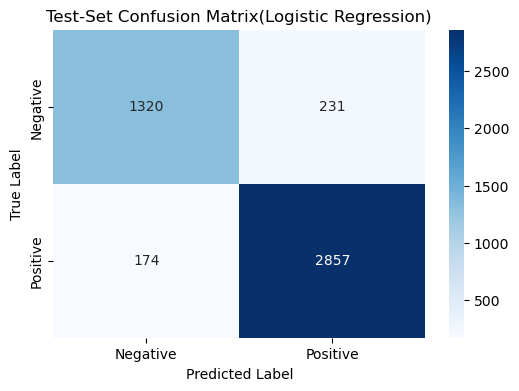

              precision    recall  f1-score   support

    Negative      0.851     0.884     0.867      1494
    Positive      0.943     0.925     0.934      3088

    accuracy                          0.912      4582
   macro avg      0.897     0.904     0.900      4582
weighted avg      0.913     0.912     0.912      4582



In [24]:
cm = confusion_matrix(y_test, test_predictions)

# Visualize confusion matrix using seaborn heatmap
classes = ["Negative", "Positive"]
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test-Set Confusion Matrix(Logistic Regression)")
plt.show()
# print(cm)
test_bow = cvec.transform(X_test)
test_predictions = lr.predict(test_bow)
print(classification_report(test_predictions, y_test,digits=3))

In [25]:
def prediction(text):
    my_text =text
    my_tokens = text_process(my_text)
#     my_tokens = list_to_str(my_tokens)
    my_bow = cvec.transform(pd.Series([my_tokens]))
    LR_predictions = lr.predict(my_bow)
#     print("Result : "+LR_predictions)
    return str(LR_predictions[0])

In [26]:
# my_text ="ดี"
# my_tokens = text_process(my_text)
# # my_tokens = list_to_str(my_tokens)
# my_bow = cvec.transform(pd.Series([my_tokens]))
# LR_predictions = lr.predict(my_bow)
# print(LR_predictions)

In [27]:
df_unseen = pd.read_csv("unseenset.csv")
df_unseen 

,Text,Sentiment
0,ท่านอาจารย์ สอนได้ดีเยี่ยม มีความรู้ความสามารถ...,Positive
1,อยากให้อาจารย์ชี้แจงรายละเอียดของงานหรืองานที่...,Positive
2,ขอบคุณอาจารย์ที่ถ่ายทอดความรู้ในรายวิชาให้ผม...,Positive
3,ขอบคุณอาจารย์ที่ได้ชี้แนะให้เห็นถึงกระบวนการ...,Positive
4,ขอให้มีความสุขค่ะ,Positive
...,...,...
5723,อยากให้อาจารย์มีคนช่วยดูหลานค่ะ,Negative
5724,อยากให้อาจารย์มีคลาสเลคเชอร์ที่สอนเองเยอะๆค่ะ ...,Negative
5725,อยากให้อาจารย์มีคลิปสอนทุกคาบ,Negative
5726,อยากให้อาจารย์มีคลิปสอนย้อนหลังครับ,Negative


In [28]:
df_unseen["Predicted_sentiment"]= df_unseen['Text'].apply(prediction)
df_unseen

,Text,Sentiment,Predicted_sentiment
0,ท่านอาจารย์ สอนได้ดีเยี่ยม มีความรู้ความสามารถ...,Positive,Positive
1,อยากให้อาจารย์ชี้แจงรายละเอียดของงานหรืองานที่...,Positive,Negative
2,ขอบคุณอาจารย์ที่ถ่ายทอดความรู้ในรายวิชาให้ผม...,Positive,Positive
3,ขอบคุณอาจารย์ที่ได้ชี้แนะให้เห็นถึงกระบวนการ...,Positive,Positive
4,ขอให้มีความสุขค่ะ,Positive,Negative
...,...,...,...
5723,อยากให้อาจารย์มีคนช่วยดูหลานค่ะ,Negative,Negative
5724,อยากให้อาจารย์มีคลาสเลคเชอร์ที่สอนเองเยอะๆค่ะ ...,Negative,Positive
5725,อยากให้อาจารย์มีคลิปสอนทุกคาบ,Negative,Negative
5726,อยากให้อาจารย์มีคลิปสอนย้อนหลังครับ,Negative,Negative


In [29]:
# df_unseen.to_excel('predictions.xlsx', index=False)

Confusion Matrix:
[[2367  497]
 [ 335 2529]]


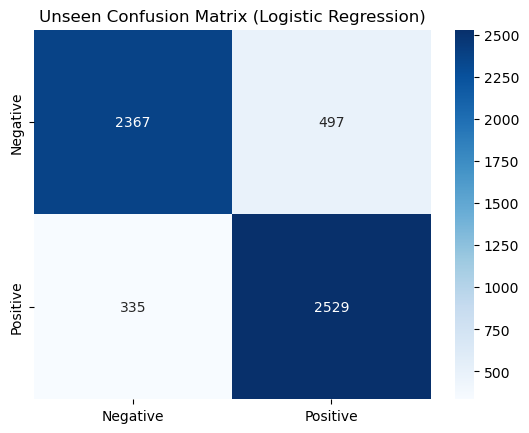

Classification Report:
              precision    recall  f1-score   support

    Negative      0.876     0.826     0.851      2864
    Positive      0.836     0.883     0.859      2864

    accuracy                          0.855      5728
   macro avg      0.856     0.855     0.855      5728
weighted avg      0.856     0.855     0.855      5728



In [30]:
conf_matrix = confusion_matrix(df_unseen["Sentiment"], df_unseen["Predicted_sentiment"])

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Unseen Confusion Matrix (Logistic Regression)')
plt.show()
# Generate classification report
report = classification_report(df_unseen["Sentiment"], df_unseen["Predicted_sentiment"],digits=3)
# Print the classification report
print("Classification Report:")
print(report)

In [31]:
import random
for i in range(9):
    print(i)
    rv = random.randint(40,100)
    print(rv)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rv)
    cvec = CountVectorizer(analyzer=lambda x:x.split(' '))
    cvec.fit_transform(X)
    train_bow = cvec.transform(X_train)
    test_bow = cvec.transform(X_test)
    lr = LogisticRegression(max_iter=1000,solver="newton-cg")
    lr.fit(train_bow, y_train)
    test_predictions = lr.predict(test_bow)
    print("Test set")
    print(classification_report(test_predictions, y_test,digits=3))
    df_unseen["Predicted_sentiment"]= df_unseen['Text'].apply(prediction)
    print("unseen")
    report = classification_report(df_unseen["Sentiment"], df_unseen["Predicted_sentiment"],digits=3)
    print(report)
    

0
51
Test set
              precision    recall  f1-score   support

    Negative      0.863     0.867     0.865      1514
    Positive      0.934     0.932     0.933      3068

    accuracy                          0.911      4582
   macro avg      0.898     0.900     0.899      4582
weighted avg      0.911     0.911     0.911      4582

unseen
              precision    recall  f1-score   support

    Negative      0.864     0.826     0.845      2864
    Positive      0.833     0.870     0.851      2864

    accuracy                          0.848      5728
   macro avg      0.849     0.848     0.848      5728
weighted avg      0.849     0.848     0.848      5728

1
90
Test set
              precision    recall  f1-score   support

    Negative      0.855     0.879     0.867      1449
    Positive      0.943     0.931     0.937      3133

    accuracy                          0.915      4582
   macro avg      0.899     0.905     0.902      4582
weighted avg      0.915     0.915     0

In [32]:
# import joblib
# # Save the model to a file
# filename = 'logreg_model.joblib'
# joblib.dump(lr, filename)

In [33]:
# loaded_model = joblib.load(filename)

In [34]:
# # Example new data
# X_new = "อร่อย"
# X_new=text_process(X_new)
# # Transform the new data using the loaded CountVectorizer
# X_new_vectorized = cvec.transform(pd.Series([X_new]))

# # Print the vectorized new data
# print("Vectorized New Data:")
# print(X_new_vectorized)

# # Make predictions using the loaded logistic regression model
# predictions = loaded_model.predict(X_new_vectorized)

# # Print the predictions
# print("Predictions:")
# print(predictions)

In [35]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf =RandomForestClassifier(max_depth=110, min_samples_leaf=1, n_estimators=200,
                       n_jobs=-1, random_state=42,oob_score=True)
classifier_rf.fit(train_bow, y_train)
classifier_rf.oob_score_

0.9124242920281552

In [36]:
classifier_rf.score(test_bow, y_test)

0.9159755565255348

In [37]:
rf_predict=classifier_rf.predict(test_bow)

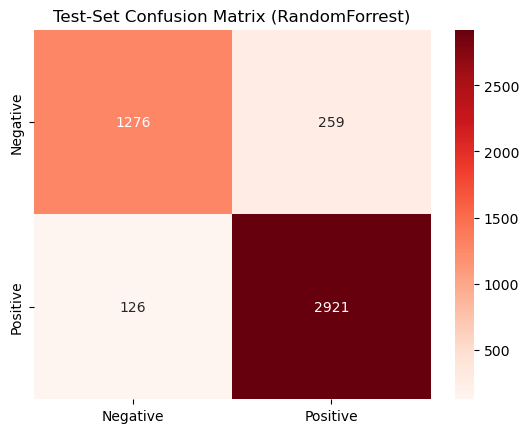

Classification Report:
              precision    recall  f1-score   support

    Negative      0.910     0.831     0.869      1535
    Positive      0.919     0.959     0.938      3047

    accuracy                          0.916      4582
   macro avg      0.914     0.895     0.904      4582
weighted avg      0.916     0.916     0.915      4582



In [38]:
true_data = y_test
predict_data=rf_predict
conf_matrix = confusion_matrix(true_data,predict_data)

# Display the confusion matrix
# print("Confusion Matrix:")
# print(conf_matrix)

# Plot the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Test-Set Confusion Matrix (RandomForrest)')
plt.show()
# Generate classification report
report = classification_report(true_data,predict_data,digits=3)
# Print the classification report
print("Classification Report:")
print(report)

In [39]:
def RF_prediction(text):
    my_text =text
    my_tokens = text_process(my_text)
    #     my_tokens = list_to_str(my_tokens)
    my_bow = cvec.transform(pd.Series([my_tokens]))
    RF_prediction=classifier_rf.predict(my_bow)
#     print("Result : "+LR_predictions)
    return str( RF_prediction[0])

In [40]:
df_unseen["RF_Prediction"]=df_unseen['Text'].apply(RF_prediction)

Confusion Matrix:
[[2323  541]
 [ 240 2624]]


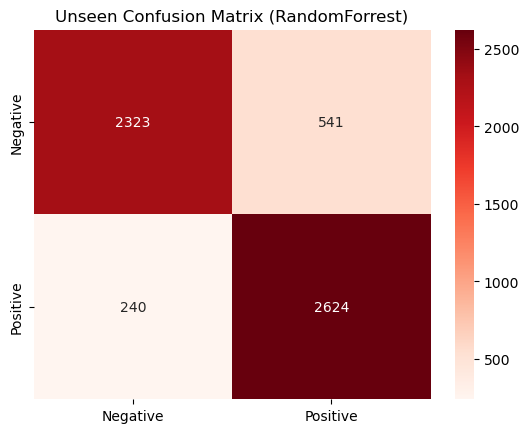

Classification Report:
              precision    recall  f1-score   support

    Negative      0.906     0.811     0.856      2864
    Positive      0.829     0.916     0.870      2864

    accuracy                          0.864      5728
   macro avg      0.868     0.864     0.863      5728
weighted avg      0.868     0.864     0.863      5728



In [41]:
true_data = df_unseen['Sentiment']
predict_data=df_unseen["RF_Prediction"]
conf_matrix = confusion_matrix(true_data,predict_data)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Unseen Confusion Matrix (RandomForrest)')
plt.show()
# Generate classification report
report = classification_report(true_data,predict_data,digits=3)
# Print the classification report
print("Classification Report:")
print(report)

In [ ]:
import random
def RF_prediction(text):
    my_text =text
    my_tokens = text_process(my_text)
    #     my_tokens = list_to_str(my_tokens)
    my_bow = cvec.transform(pd.Series([my_tokens]))
    RF_prediction=classifier_rf.predict(my_bow)
#     print("Result : "+LR_predictions)
    return str( RF_prediction[0])

for i in range(10):
    depth = random.randint(50, 140)
    leaf = random.randint(1, 10)
    n = random.randint(40, 90)
    rv = 42
    print("Randomforest")
    print(depth)
    print(leaf)
    print(n)
    print(rv)
    classifier_rf =RandomForestClassifier(max_depth=depth, min_samples_leaf=leaf, n_estimators=n,
                       n_jobs=-1, random_state=rv,oob_score=True)
    classifier_rf.fit(train_bow, y_train)
    rf_predict=classifier_rf.predict(test_bow)
    report = classification_report(rf_predict,y_test,digits=3)
    # Print the classification report
    print("RF Test-Report:")
    print(report)
    df_unseen["RF_Prediction"]=df_unseen['Text'].apply(RF_prediction)
    report = classification_report(df_unseen["RF_Prediction"],df_unseen["Sentiment"],digits=3)
    print("RF Unseen-Report:")
    print(report)

Randomforest
50
7
64
42
RF Test-Report:
              precision    recall  f1-score   support

    Negative      0.635     0.919     0.751      1060
    Positive      0.972     0.841     0.902      3522

    accuracy                          0.859      4582
   macro avg      0.803     0.880     0.826      4582
weighted avg      0.894     0.859     0.867      4582



In [ ]:
# import joblib 
# joblib.dump(lr,"Logis2.pkl")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pandas as pd
from pythainlp.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load sample data
sentences = df['Text']

# Tokenize Thai sentences using PyThaiNLP
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Create a tokenizer instance
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_sentences)

# Convert words to indices using the tokenizer
sequences = tokenizer.texts_to_sequences(tokenized_sentences)

# Set max_length
max_length = 8

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Vocabulary size (including padding)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
# Embedding dimension
embedding_dim = 100

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='softmax'))
# Display the model summary
model.summary()
# labels = np.array(df['Sentiment'])
# # Convert text labels to numerical values
label_encoder = LabelEncoder()
df['Numeric_Sentiment'] = df['Sentiment']
labels_numeric = label_encoder.fit_transform( df['Numeric_Sentiment'] )
labels_numeric=df['Numeric_Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Numeric_Sentiment'], test_size=0.2, random_state=42)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train,y_train, epochs=50, batch_size=5000)

# Evaluate the model on the training set
loss, accuracy = model.evaluate(padded_sequences,labels_numeric)
print(f"Training Loss: {loss:.3f}, Training Accuracy: {accuracy:.2f}")

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Predict probabilities on the entire dataset
predicted_probs = model.predict(padded_sequences)

# Convert probabilities to class predictions using a threshold (e.g., 0.5)
predicted_labels = (predicted_probs > 0.5).astype(int)

# Convert pandas Series to NumPy array and flatten
labels_numeric = np.array(labels_numeric).flatten()

# Generate confusion matrix
conf_matrix = confusion_matrix(labels_numeric, predicted_labels)
class_report = classification_report(labels_numeric, predicted_labels)
# Calculate accuracy
accuracy = accuracy_score(labels_numeric, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Test-Set Confusion Matrix (CNNs)')
plt.show()
print(f"Accuracy: {accuracy:.2f}")
print(class_report)



In [ ]:
# # Assuming you have the trained model and unseen_text_data
# # Use the same tokenizer and padding configuration used during training

# # Tokenize and pad sequences for unseen data
# unseen_sequences = tokenizer.texts_to_sequences(df_unseen['Text'])
# padded_unseen_sequences = pad_sequences(unseen_sequences, maxlen=max_length, padding='post', truncating='post')

# # Make predictions
# predictions = model.predict(padded_unseen_sequences)

# # Convert probability predictions to binary predictions (0 or 1)
# binary_predictions = (predictions > 0.5).astype(int)

# # Decode binary predictions back to original labels
# predicted_labels = label_encoder.inverse_transform(binary_predictions.flatten())

# # Display or use the predicted labels as needed
# print(predicted_labels)


In [ ]:
def CNN_prediction(text):
    new_sentences = text

    # Tokenize new Thai sentences
    tokenized_new_sentences = [word_tokenize(sentence) for sentence in new_sentences]

    # Convert words to indices using the tokenizer
    sequences_new = tokenizer.texts_to_sequences(tokenized_new_sentences)

    # Padding for the new sequences
    padded_sequences_new = pad_sequences(sequences_new, maxlen=max_length, padding='post', truncating='post')

    # Make predictions
    predictions = model.predict(padded_sequences_new)

    # Convert probability predictions to class labels (0 or 1)
    predicted_classes = (predictions > 0.5).astype(int)

    # Return the text label corresponding to the predicted class index
    predicted_label_text = label_encoder.inverse_transform(predicted_classes.flatten())[0]

    return predicted_label_text

# Assuming df_unseen already contains a 'Text' column
new_sentences = df_unseen['Text']

# Tokenize new Thai sentences
tokenized_new_sentences = [word_tokenize(sentence) for sentence in new_sentences]

# Convert words to indices using the tokenizer
sequences_new = tokenizer.texts_to_sequences(tokenized_new_sentences)

# Padding for the new sequences
padded_sequences_new = pad_sequences(sequences_new, maxlen=max_length, padding='post', truncating='post')

# Make predictions
predictions = model.predict(padded_sequences_new)

# Convert probability predictions to class labels (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Convert numerical class labels back to text labels
predicted_labels_text = label_encoder.inverse_transform(predicted_classes.flatten())

# Add a new column to the DataFrame for predicted labels
df_unseen['Predicted_Label_CNN'] = predicted_labels_text

# Display the DataFrame with the new predictions
print(df_unseen)

# Assuming df_unseen already contains 'Text', 'Actual_Label', and 'Predicted_Label' columns
actual_labels_text = df_unseen['Sentiment']

# Convert actual labels to numerical values
actual_labels_numeric = label_encoder.transform(actual_labels_text)

# Calculate accuracy
accuracy = np.mean(predicted_classes.flatten() == actual_labels_numeric)

# Print accuracy
print(f"Accuracy on Unseen Data: {accuracy:.2f}")

In [ ]:
true_data = df_unseen["Sentiment"]
predict_data=df_unseen["Predicted_Label_CNN"]
conf_matrix = confusion_matrix(true_data,predict_data)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Unseen-Set Confusion Matrix (CNNs)')
plt.show()
# Generate classification report
report = classification_report(true_data,predict_data)
# Print the classification report
print("Classification Report:")
print(report)

In [ ]:
# test
text="สอนดีมากๆๆๆ"
print(prediction(text))
print(RF_prediction(text))
print(CNN_prediction(text))

In [ ]:
# from collections import Counter

# def get_predictions(text):
#     # Assuming you have the prediction functions defined
#     prediction1 = prediction(text)
#     prediction2 = RF_prediction(text)
#     prediction3 = CNN_prediction(text)

#     # Combine predictions into a list
#     predictions = [prediction1, prediction2, prediction3]
#     return predictions

# def most_common_value(predictions):
#     # Use Counter to count occurrences of each prediction
#     counter = Counter(predictions)

#     # Find the most common prediction
#     most_common = counter.most_common(1)

#     # Return the most common prediction and its count
#     return most_common[0] if most_common else None

# # Example usage
# text = "อะไร"
# predictions = get_predictions(text)
# result = most_common_value(predictions)
# print("Most Common Prediction:", result[0] if result else None)
# print("Count:", result[1] if result else None)
# print(int((result[1]/3)*100),str("%"))

In [ ]:
df_unseen

In [ ]:
# # df_unseen.to_excel('predictions.xlsx', index=False)
# import joblib
# # Save the model to a file
# filename = 'logreg_model.joblib'
# joblib.dump(lr, filename)
# joblib.dump(model,"CNNs.joblib")
# joblib.dump(classifier_rf,"RF.joblib")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
df_unseen = pd.read_csv("unseenset.csv")
df_unseen 

def prediction(text):
    my_text =text
    my_tokens = text_process(my_text)
#     my_tokens = list_to_str(my_tokens)
    my_bow = cvec.transform(pd.Series([my_tokens]))
    LR_predictions = lr.predict(my_bow)
#     print("Result : "+LR_predictions)
    return str(LR_predictions[0])
def RF_prediction(text):
    my_text =text
    my_tokens = text_process(my_text)
    #     my_tokens = list_to_str(my_tokens)
    my_bow = cvec.transform(pd.Series([my_tokens]))
    RF_prediction=classifier_rf.predict(my_bow)
#     print("Result : "+LR_predictions)
    return str( RF_prediction[0])

rv=[42,47,52,57,62,67,72,77,82,87]
leaf=[1,2,3,4,5,6,7,8,9,10]
depth=[50,60,70,80,90,100,110,120,130,140]
n=[100,110,120,130,140,150,160,170,180,200]
for i in range(len(rv)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rv[i])
    lr = LogisticRegression(max_iter=2000,solver="newton-cg")
    train_bow = cvec.transform(X_train)
    lr.fit(train_bow, y_train)
    test_bow = cvec.transform(X_test)
    test_predictions = lr.predict(test_bow)
    print("LR test-Report"+str(i))
    print(classification_report(test_predictions, y_test,digits=3))
    df_unseen["Predicted_sentiment"]= df_unseen['Text'].apply(prediction)
    report = classification_report(df_unseen["Predicted_sentiment"],df_unseen["Sentiment"])
    print("LR Unseen-Report"+str(i))
    print(report)
    
    print("Randomforest")
    
    classifier_rf =RandomForestClassifier(max_depth=depth[i], min_samples_leaf=leaf[i], n_estimators=n[i],
                       n_jobs=-1, random_state=rv[i],oob_score=True)
    classifier_rf.fit(train_bow, y_train)
    rf_predict=classifier_rf.predict(test_bow)
    report = classification_report(rf_predict,y_test,digit=3)
    # Print the classification report
    print("RF Test-Report:")
    print(report)
    df_unseen["RF_Prediction"]=df_unseen['Text'].apply(RF_prediction)
    report = classification_report(df_unseen["RF_Prediction"],df_unseen["Sentiment"])
    print("RF Unseen-Report:")
    print(report)